In [1]:
import gc
import ast
import json
import numpy as np
import pandas as pd

import catboost
from catboost import CatBoostClassifier, cv, Pool

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
from scipy.stats import pointbiserialr
from tqdm import tqdm

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from tqdm import tqdm

from scipy import stats
from torch.utils.data import DataLoader, TensorDataset

# Data preparation
Data preparation functions

In [ ]:
def parse_answer(s):
    try:
        return json.loads(s[0:s.find('}') + 1])
    except:
        return {'answer': 'X', 'explanation': s}

def prep_chunk(s, shrink = True, sh_len = 3000, softmax = False):
    df = pd.read_csv(s)
    df['probs'] = df['probs'].apply(json.loads)
    df['probs'] = df['probs'].apply(np.array)
    df['model_answer'] = df['answer'].apply(lambda x: parse_answer(x)['answer'])
    df['is_right'] = df['model_answer'] == df['right_answer']
    df['is_right'] = df['is_right'].apply(lambda x: int(x))
    df = df.drop(df[df['model_answer'] == 'X'].index)
    res = pd.DataFrame()
    if shrink:
        res['X'] = df['probs'].apply(lambda x: np.sort(x)[::-1][:sh_len])
    else:
        res['X'] = df['probs'].apply(lambda x: np.sort(x)[::-1])
    if softmax:
        res['X'] = res['X'].apply(lambda x: F.softmax(torch.tensor(x.copy()), dim=-1).numpy())
    res['y'] = df['is_right']
    del df
    return res

def prep_chunk_nosort(s, shrink = True, sh_len = 3000, softmax = False):
    df = pd.read_csv(s)
    df['probs'] = df['probs'].apply(json.loads)
    df['probs'] = df['probs'].apply(np.array)
    df['model_answer'] = df['answer'].apply(lambda x: parse_answer(x)['answer'])
    df['is_right'] = df['model_answer'] == df['right_answer']
    df['is_right'] = df['is_right'].apply(lambda x: int(x))
    df = df.drop(df[df['model_answer'] == 'X'].index)
    res = pd.DataFrame()
    if shrink:
        res['X'] = df['probs'].apply(lambda x: x[:sh_len])
    else:
        res['X'] = df['probs']
    if softmax:
        res['X'] = res['X'].apply(lambda x: F.softmax(torch.tensor(x.copy()), dim=-1).numpy())
    res['y'] = df['is_right']
    del df
    return res

def prep_data(s):
    df = pd.read_csv(s)
    df['X'] = df['probs'].apply(json.loads).apply(np.array)
    df['stds'] = df['stds'].apply(json.loads).apply(np.array)
    df['medians'] = df['medians'].apply(json.loads).apply(np.array)
    df['means'] = df['means'].apply(json.loads).apply(np.array)
    df['modes'] = df['modes'].apply(json.loads).apply(np.array)
    df['entropy'] = df['entropy'].apply(json.loads).apply(np.array)
    df['prev_dist'] = df['prev_dist'].apply(json.loads).apply(np.array)
    df['model_answer'] = df['answer'].apply(lambda x: parse_answer(x)['answer'])
    df['y'] = df['model_answer'] == df['right_answer']
    df['y'] = df['y'].apply(lambda x: int(x))
    df = df.drop(df[df['model_answer'] == 'X'].index)
    df = df.drop('probs', axis=1)
    df = df.drop('answer', axis=1)
    df = df.drop('question', axis=1)
    df = df.drop('right_answer', axis=1)
    df = df.drop('model_answer', axis=1)
    return df

def add_pads(x, m_shape):
    if x.shape[0] < m_shape:
        return np.pad(x, ((0, m_shape-x.shape[0])), mode='constant')[0:m_shape]
    elif x.shape[0] > m_shape:
        return x[0:m_shape]
    else:
        return x[0:m_shape]

Loading dataset

In [2]:
cybermetrics_data = pd.concat([prep_data(r'C:\Work\Thesis\datasets\stats\llama323b_8bit_cyber' + str(i) + r'.csv') for i in range(5)], ignore_index=True, sort=False)
cybermetrics_data['size'] = cybermetrics_data['X'].apply(lambda x: x.shape[0])

Preparing feature vector

In [4]:
def dists(x):
    return np.absolute(np.pad(x[1:], (0, 1), mode='constant') - x)

def entropy_out(x):
    t = 0.65
    return np.unique(np.absolute(x) > t, return_counts = True)[1][1]/x.shape[0]

def compose_features_means(x):
    return np.array((np.mean(x['medians']), np.mean(x['means']), np.mean(x['stds']), np.mean(x['modes']), np.mean(x['entropy']), np.mean(x['dists']), entropy_out(x['entropy'])))

def compose_features_medians(x):
    return np.array((np.median(x['medians']), np.median(x['means']), np.median(x['stds']), np.median(x['modes']), np.median(x['entropy']), np.median(x['dists'])))

def compose_features_stds(x):
    return np.array((np.std(x['medians']), np.std(x['means']), np.std(x['stds']), np.std(x['modes']), np.std(x['entropy']), np.std(x['dists'])))

def compose_features(x):
    result = np.concatenate((compose_features_means(x), compose_features_medians(x)))
    return np.concatenate((result, compose_features_stds(x)))


cybermetrics_data['dists'] = cybermetrics_data['prev_dist'].apply(dists)
cybermetrics_data['features'] = cybermetrics_data[['medians', 'means', 'stds', 'modes', 'entropy', 'dists']].apply(lambda x: compose_features(x), axis=1)
cybermetrics_data['entropy_metric'] = cybermetrics_data['entropy'].apply(entropy_out)

# Logistic regression
Training

In [5]:
from sklearn import linear_model

logr = linear_model.LogisticRegression()
X = np.stack(cybermetrics_data['features'])#.to_numpy().reshape(-1,1)
y = cybermetrics_data['y'].to_numpy()

print(type(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logr.fit(X_train, y_train)
y_pred = logr.predict(X_test)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("F1:", f1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

<class 'numpy.ndarray'>
Accuracy: 0.7068965517241379
F1: 0.8222996515679443

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.10      0.16       251
           1       0.72      0.95      0.82       619

    accuracy                           0.71       870
   macro avg       0.59      0.53      0.49       870
weighted avg       0.65      0.71      0.63       870



C:\Users\sndrgn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Implementing Transformer for classification
Datasets preparation

In [85]:
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = StandardScaler()

X = np.stack(cybermetrics_data['features'])
y = cybermetrics_data['y'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
print('Complete')

Complete


Setting up NN architecture and training model

In [86]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_weights = torch.tensor([3.0, 1.0], dtype=torch.float32).to(device)
print("Class Weights:", class_weights)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.ln = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(-1) 
        elif x.dim() != 3:
            raise ValueError(f"Input tensor must have shape (batch_size, sequence_length, num_features). Got {x.shape}")

        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        lstm_out = self.ln(lstm_out)
        lstm_out = self.dropout(lstm_out)
        lstm_out = self.fc(lstm_out)
        return self.sigmoid(lstm_out)

class TransformerClassifier(nn.Module):
    def __init__(self, feature_dim, num_heads=6, num_layers=3, hidden_dim=128):
        super().__init__()
        self.input_proj = nn.Linear(feature_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.dropout1 = nn.Dropout(0.1)
        self.ln1 = nn.LayerNorm(hidden_dim//2)
        self.bn1 = nn.BatchNorm1d(hidden_dim//2)
        self.fc2 = nn.Linear(hidden_dim//2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_proj(x).unsqueeze(1)  # (batch_size, seq_len=1, hidden_dim)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = F.leaky_relu(self.ln1(self.fc1(x)), negative_slope=0.02)
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

input_size = X.shape[1]
hidden_size = 64
output_size = 1

#model = LSTMModel(input_size, hidden_size, output_size).to(device)
model = TransformerClassifier(input_size, hidden_size, output_size).to(device)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

#criterion = nn.BCELoss(weight=class_weights[1])
criterion = nn.BCEWithLogitsLoss(weight=class_weights[1])
optimizer = optim.Adam(model.parameters(), lr=0.005)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)

    for inputs, labels in train_loader_tqdm:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())
        gc.collect()
        torch.cuda.empty_cache()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

C:\Users\sndrgn\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Class Weights: tensor([3., 1.], device='cuda:0')


Epoch [1/20]:   0%|                                                                            | 0/109 [00:00<?, ?it/s]C:\Users\sndrgn\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [1/20], Loss: 0.5714


Epoch [2/20], Loss: 0.5448


Epoch [3/20], Loss: 0.5474


Epoch [4/20], Loss: 0.5451


Epoch [5/20], Loss: 0.5510


Epoch [6/20], Loss: 0.5471


Epoch [7/20], Loss: 0.5436


Epoch [8/20], Loss: 0.5446


Epoch [9/20], Loss: 0.5506


Epoch [10/20], Loss: 0.5462


Epoch [11/20], Loss: 0.5451


Epoch [12/20], Loss: 0.5484


Epoch [13/20], Loss: 0.5498


Epoch [14/20], Loss: 0.5475


Epoch [15/20], Loss: 0.5516


Epoch [16/20], Loss: 0.5517


Epoch [17/20], Loss: 0.5415


Epoch [18/20], Loss: 0.5479


Epoch [19/20], Loss: 0.5452


Epoch [20/20], Loss: 0.5454


Evaluating model on test dataset

In [87]:
# Evaluation
model.eval()
y_true = y_test.cpu().tolist()
y_pred_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        try:
            y_pred_probs.extend(list(outputs.to('cpu').numpy().squeeze()))
        except Exception:
            continue
        
#y_pred_probs
y_pred_probs = scaler.fit_transform(np.array(y_pred_probs).reshape(-1, 1))
y_pred_probs = y_pred_probs.reshape(1,-1)[0]
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
pd.DataFrame(y_pred_probs).describe()


Classification Report:
              precision    recall  f1-score   support

         0.0       0.28      0.45      0.35       251
         1.0       0.71      0.54      0.61       619

    accuracy                           0.51       870
   macro avg       0.49      0.49      0.48       870
weighted avg       0.58      0.51      0.53       870



,0
count,8.700000e+02
mean,-2.904870e-08
std,1.000575e+00
min,-1.365454e+00
25%,-9.686897e-01
50%,-1.666357e-01
75%,1.049505e+00
max,1.468514e+00


In [91]:
treshold = -0.4
y_pred_probs = np.array(y_pred_probs)
y_pred = (y_pred_probs > treshold).astype(int)

accuracy = accuracy_score(y_test.to('cpu').numpy(), y_pred)
f1 = f1_score(y_test.to('cpu').numpy(), y_pred)
y_trsh = (y_pred_probs >= treshold).astype(int)
roc_auc = roc_auc_score(y_pred, y_trsh)
curve = []
for treshold in np.arange(-2, 2, 0.05):
    y_trsh = (y_pred_probs > treshold).astype(int)
    fpr, tpr, thresholds = roc_curve(y_test.to('cpu').numpy(), y_trsh)
    curve.append((fpr[1], tpr[1], treshold))

curve = np.array(curve)

print("Accuracy:", accuracy)
print("F1:", f1)
print("ROC-AUC:", roc_auc)
print("\nClassification Report:")
print(classification_report(y_test.to('cpu').numpy(), y_pred))

Accuracy: 0.5873563218390805
F1: 0.6727438468550593
ROC-AUC: 1.0

Classification Report:
              precision    recall  f1-score   support

         0.0       0.36      0.57      0.44       251
         1.0       0.77      0.60      0.67       619

    accuracy                           0.59       870
   macro avg       0.57      0.58      0.56       870
weighted avg       0.65      0.59      0.61       870



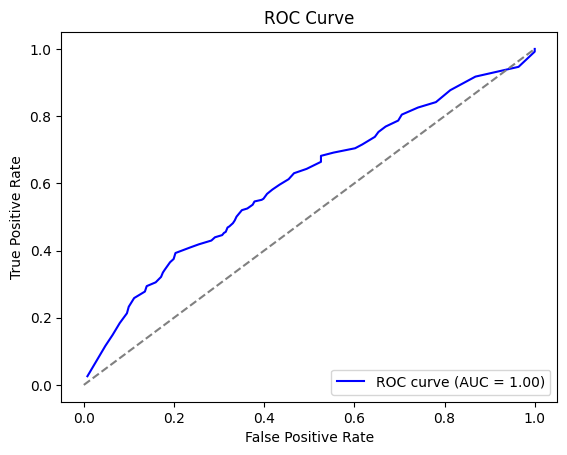

In [95]:
plt.figure()
plt.plot(curve[10:-10,0], curve[10:-10,1], color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Implementing Catboost classifier

In [6]:
array_X = np.stack(cybermetrics_data['features'])#.to_numpy().reshape(-1,1)
array_y = cybermetrics_data['y'].to_numpy()

In [7]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'depth': [4, 6]
}

random_search = RandomizedSearchCV(
    estimator=CatBoostClassifier(
        loss_function='Logloss', 
        task_type='GPU',
        verbose=0, 
        allow_writing_files=False,
    ),
    param_distributions=param_grid,
    cv=skf,
    scoring='f1',
    n_jobs=1,
    n_iter=10,
    random_state=42
)

gc.collect()
random_search.fit(array_X, array_y)

print("Best parameters:", random_search.best_params_)
print("Best F1 score:", random_search.best_score_)

Best parameters: {'learning_rate': 0.01, 'l2_leaf_reg': 1, 'iterations': 100, 'depth': 4}
Best F1 score: 0.8422014975780912


In [8]:
X_train, X_test, y_train, y_test = train_test_split(array_X, array_y, test_size=0.2, stratify=y, random_state=42)

class_weights = {0: 3.0, 1: 1.0}

params = {}
params = random_search.best_params_
params['loss_function'] = 'Logloss'
params['subsample'] = 0.8
params['bootstrap_type'] = 'MVS'
params['task_type'] = 'GPU'
params['class_weights'] = class_weights

model = CatBoostClassifier(**params)
model.fit(X_train, y_train)
model.save_model('cyber_llama3238b.cbm')

0:	learn: 0.6922115	total: 23.4ms	remaining: 2.32s
1:	learn: 0.6912915	total: 25.7ms	remaining: 1.26s
2:	learn: 0.6902913	total: 28.1ms	remaining: 907ms
3:	learn: 0.6893787	total: 30.5ms	remaining: 731ms
4:	learn: 0.6884588	total: 32.8ms	remaining: 623ms
5:	learn: 0.6876166	total: 35.2ms	remaining: 551ms
6:	learn: 0.6866578	total: 37.4ms	remaining: 497ms
7:	learn: 0.6857847	total: 39.8ms	remaining: 457ms
8:	learn: 0.6849570	total: 42ms	remaining: 425ms
9:	learn: 0.6840826	total: 44ms	remaining: 396ms
10:	learn: 0.6832582	total: 46.3ms	remaining: 374ms
11:	learn: 0.6824493	total: 48.3ms	remaining: 354ms
12:	learn: 0.6816194	total: 50.4ms	remaining: 337ms
13:	learn: 0.6807418	total: 52.6ms	remaining: 323ms
14:	learn: 0.6799088	total: 54.6ms	remaining: 310ms
15:	learn: 0.6791803	total: 56.9ms	remaining: 299ms
16:	learn: 0.6783867	total: 59ms	remaining: 288ms
17:	learn: 0.6775787	total: 61.2ms	remaining: 279ms
18:	learn: 0.6768166	total: 63.4ms	remaining: 270ms
19:	learn: 0.6760219	total: 

Evaluating trained model on test dataset

In [57]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
treshold = 0.47
y_trsh = (y_pred_proba[:, 1] > treshold).astype(int)
roc_auc = roc_auc_score(y_test, y_trsh)
curve = []
for trs in np.arange(0, 1.05, 0.05):
    y_trsh = (y_pred_proba[2:-2, 1] > trs).astype(int)
    fpr, tpr, trs = roc_curve(y_test[2:-2], y_trsh)
    curve.append((fpr[1], tpr[1], treshold))

curve = np.array(curve)

print("Accuracy:", accuracy)
print("F1:", f1)
print("ROC-AUC:", roc_auc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(classification_report(y_test, (y_pred_proba[:, 1] > treshold).astype(int)))

Accuracy: 0.5540229885057472
F1: 0.6196078431372549
ROC-AUC: 0.5974231464737794

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.70      0.46       238
           1       0.81      0.50      0.62       632

    accuracy                           0.55       870
   macro avg       0.58      0.60      0.54       870
weighted avg       0.69      0.55      0.58       870

              precision    recall  f1-score   support

           0       0.36      0.57      0.44       238
           1       0.79      0.62      0.70       632

    accuracy                           0.61       870
   macro avg       0.58      0.60      0.57       870
weighted avg       0.68      0.61      0.63       870



In [24]:
pd.DataFrame(y_pred_proba).describe()

,0,1
count,870.000000,870.000000
mean,0.501219,0.498781
std,0.091152,0.091152
min,0.317684,0.318658
25%,0.429482,0.424290
50%,0.515719,0.484281
75%,0.575710,0.570518
max,0.681342,0.682316


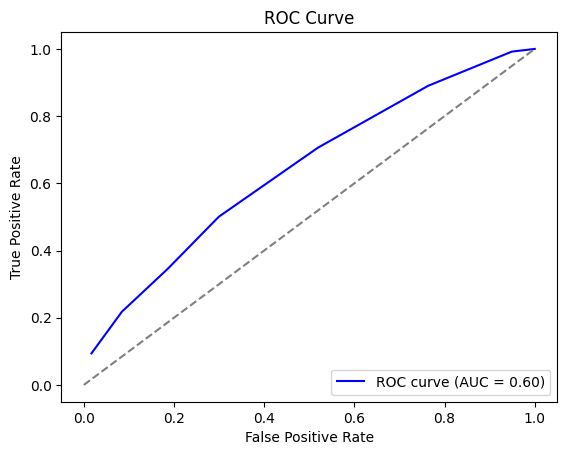

In [58]:
plt.figure()
plt.plot(curve[6:-7,0], curve[6:-7,1], color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## LGBM classifier

In [ ]:
from lightgbm import LGBMClassifier

X = cybermetrics_data['X']
y = cybermetrics_data['y']

pca = PCA(n_components=500, random_state=42)
array_X = np.stack(X)
array_y = np.array(y)
X_reduced = pca.fit_transform(array_X)

smote = SMOTE(random_state=42)
adasyn = ADASYN(sampling_strategy=1, n_neighbors=10, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_reduced, array_y)
print("Resampled class counts:", np.bincount(y_resampled))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'num_leaves': [20, 31, 50],
    'min_child_weight': [1e-3, 1e-2, 1e-1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 1, 10],
    'reg_lambda': [0, 1, 10]
}

random_search = RandomizedSearchCV(
    estimator=LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        device='gpu',
        verbose=-1,
        class_weight='balanced'
    ),
    param_distributions=param_grid,
    cv=skf,
    scoring='f1',
    n_jobs=-1,
    n_iter=10,
    random_state=42
)

gc.collect()
random_search.fit(X_resampled, y_resampled)

print("Best parameters:", random_search.best_params_)
print("Best F1 score:", random_search.best_score_)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

params = random_search.best_params_
params['objective'] = 'binary'
params['boosting_type'] = 'gbdt'
params['device'] = 'gpu'
params['is_unbalance']=True

model = LGBMClassifier(**params)
model.fit(X_train, y_train)


In [ ]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
treshold = 0.5
y_trsh = (y_pred_proba[:, 1] > treshold).astype(int)
roc_auc = roc_auc_score(y_test, y_trsh)
curve = []
for treshold in np.arange(0, 1.05, 0.05):
    y_trsh = (y_pred_proba[:, 1] > treshold).astype(int)
    fpr, tpr, thresholds = roc_curve(y_test, y_trsh)
    curve.append((fpr[1], tpr[1], treshold))

curve = np.array(curve)

print("Accuracy:", accuracy)
print("F1:", f1)
print("ROC-AUC:", roc_auc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
plt.figure()
plt.plot(curve[0:-2,0], curve[0:-2,1], color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Feed forward MLP NN

In [59]:
array_X = np.stack(cybermetrics_data['features'])
array_y = cybermetrics_data['y'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(array_X, array_y, test_size=0.2, random_state=42, stratify=array_y)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = StandardScaler()
X_train_tensor = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32).to(device)
X_test = scaler.transform(X_test)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
print('Data complete')

class FeedForwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.1)

        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.dropout4 = nn.Dropout(0.05)
        
        self.out = nn.Linear(64, 1)  # Output layer for binary classification

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)), negative_slope=0.01)
        x = self.dropout1(x)
        x = F.leaky_relu(self.bn2(self.fc2(x)), negative_slope=0.01)
        x = self.dropout2(x)
        x = F.leaky_relu(self.bn3(self.fc3(x)), negative_slope=0.01)
        x = self.dropout3(x)
        x = F.leaky_relu(self.bn4(self.fc4(x)), negative_slope=0.01)
        x = self.dropout4(x)        
        x = torch.sigmoid(self.out(x))
        return x

input_dim = X_train_tensor.shape[1]

model = FeedForwardNN(input_dim).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)

num_epochs = 100
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print('Datasets ready')

print('Traning....')
model.train()
for epoch in range(num_epochs):
    gc.collect()
    torch.cuda.empty_cache()
    epoch_loss = 0
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
        for batch_X, batch_y in pbar:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            y_pred = model(batch_X).squeeze()
            loss = criterion(y_pred, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix(loss=f"{loss.item():.4f}")

print('Traning complete')

Data complete
Datasets ready
Traning....


Epoch 100/100: 100%|████████████████████████████████████████████████| 109/109 [00:00<00:00, 183.19batch/s, loss=0.6049]

Traning complete


Evaluating trained model on test dataset 

In [74]:
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor).to('cpu').squeeze().numpy()
    y_pred = (y_pred_prob >= 0.997).astype(int)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# Classification Report
print("Accuracy:", accuracy)
print("F1:", f1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
pd.DataFrame(y_pred_prob).describe()

Accuracy: 0.5793103448275863
F1: 0.6684782608695652

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.57      0.42       238
           1       0.78      0.58      0.67       632

    accuracy                           0.58       870
   macro avg       0.56      0.58      0.55       870
weighted avg       0.66      0.58      0.60       870



,0
count,8.700000e+02
mean,7.202370e-01
std,4.200791e-01
min,1.308128e-07
25%,2.041723e-01
50%,9.987363e-01
75%,9.999901e-01
max,1.000000e+00


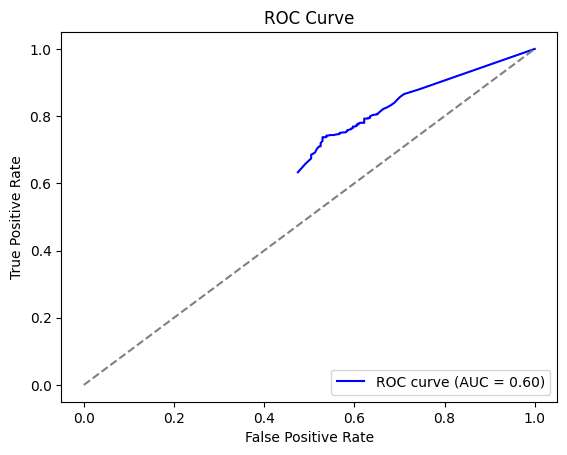

In [84]:
treshold = 0.8
y_trsh = (y_pred_prob > treshold).astype(int)
roc_auc = roc_auc_score(y_test, y_trsh)
curve = []
for treshold in np.arange(0, 1.01, 0.01):
    y_trsh = (y_pred_prob > treshold).astype(int)
    fpr, tpr, thresholds = roc_curve(y_test, y_trsh)
    curve.append((fpr[1], tpr[1], treshold))

curve = np.array(curve)

plt.figure()
plt.plot(curve[0:-1,0], curve[0:-1,1], color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
gc.collect()
torch.cuda.empty_cache()